In [1]:
import os 
import numpy as np 
import annoy
import cv2
import dlib
import random
from PIL import Image
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from facenet_basemodel import FaceNet

In [3]:
face_detector = dlib.get_frontal_face_detector()

In [4]:
model = FaceNet()
model = model.loadModel('./facenet_weights.h5')

Ready


In [5]:
representations = []

for f in tqdm(os.listdir('./BNK48/BNK48Test/'), total=len(os.listdir('./BNK48/BNK48Test/'))):
    if('.jpg' in f):
        img = cv2.imread('./BNK48/BNK48Test/'+f)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         gray_img = np.array(gray_img)
        faces = face_detector(img)
        for face in faces:
            x = face.left()
            y = face.top()
            w = face.right() - x +10
            h = face.bottom() - y +10
            crop_face = img[y : h + y, x : x+w]
        exdims_img = np.expand_dims(crop_face,axis=0)
        embreded_face = model.predict(exdims_img)[0,:]
        representation = []
        representation.append('./BNK48/BNK48Test/'+f)
        representation.append(embreded_face)
        representations.append(representation)
        # (1,160,160,3)

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:03<00:08,  1.75s/it]

100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


In [6]:

embedding_size=128
for i in range(7, 1000000): #1M instances
    key = './BNK48/BNK48Test/img_%d.jpg' % (i)
    vector = [random.gauss(-0.35, 0.48) for z in range(embedding_size)]
    dummy_item = []
    dummy_item.append(key)
    dummy_item.append(vector)
    representations.append(dummy_item)

In [7]:
len(representations)

999999

In [ ]:
t = annoy.AnnoyIndex(embedding_size, 'euclidean')
 
for i in range(0, len(representations)):
    representation = representations[i]
    img_path = representation[0]
    embedding = representation[1]
    t.add_item(i, embedding)
t.build(10) #10 trees
t.save('euclidean.tree')

In [ ]:
t = annoy.AnnoyIndex(embedding_size, 'angular')
 
for i in range(0, len(representations)):
    representation = representations[i]
    img_path = representation[0]
    embedding = representation[1]
    t.add_item(i, embedding)

t.build(10) #10 trees
t.save('angular.tree')

In [11]:
width=5
height=5
rows = 1
axes=[]
cols = 2
fig=plt.figure()

class face_recognition:
    def __init__(self, model='angular'):
        
        self.t = annoy.AnnoyIndex(embedding_size, model)
        self.t.load(f'./{model}.tree')
        
    def findmatch(self, source_path):
        t_start = datetime.datetime.now()
        img = cv2.imread(source_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = np.array(gray_img)
        faces = face_detector(img)
        for i,face in enumerate(faces):
                x = face.left()
                y = face.top()
                w = face.right() - x +10
                h = face.bottom() - y +10
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 25, 10), 2)
                cv2.imwrite(f"data_{i}.png",img)
                crop_face = img[y : h + y, x : x+w]
        exdims_img = np.expand_dims(crop_face, axis=0)
        face_encoded = model.predict(exdims_img)[0,:]
        t0 = datetime.datetime.now()
        match = self.t.get_nns_by_vector(face_encoded, n=2, include_distances=True)
        print(f"Query time use: {datetime.datetime.now()- t0}")
        print(f"All time use: {datetime.datetime.now()- t_start}")
        for idx, distance in zip(match[0],match[1]):
            img = cv2.imread(representations[idx][0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image_name =  representations[idx][0].split('/')[-1]
#             
            for i in range(cols*rows):
                fig.add_subplot(rows, cols,i+1)
                plt.title(f"{image_name} Distance {distance}")
                plt.imshow(img)
            fig.tight_layout()

            plt.show()
            

            
        


<Figure size 432x288 with 0 Axes>

Query time use: 0:00:00.000220
All time use: 0:00:00.415103


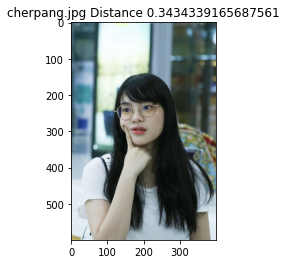

<ipython-input-11-04230a489097>:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(rows, cols,i+1)


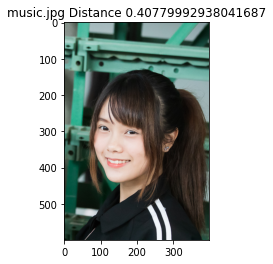

In [12]:
face_recognition =  face_recognition()
face_recognition.findmatch(source_path='./Screen Shot 2018-02-20 at 7.20.31 PM.png')